### Imports & Display Options

In [1]:
%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 100

In [2]:
from matplotlib import pylab

In [3]:
import numpy as np
import feather
from datetime import datetime
import re

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [5]:
from keras.utils import np_utils
from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.callbacks import TensorBoard

Using TensorFlow backend.


### Import Data & Clean

In [6]:
df = pd.read_csv('./BasicCompanyDataAsOneFile-2018-03-01.csv', nrows=2000000)
df.head()

/Users/zeb.zhao/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (39,40,41,42,43,44,45,46,47,48,49,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,CompanyCategory,CompanyStatus,CountryOfOrigin,DissolutionDate,IncorporationDate,Accounts.AccountRefDay,Accounts.AccountRefMonth,Accounts.NextDueDate,Accounts.LastMadeUpDate,Accounts.AccountCategory,Returns.NextDueDate,Returns.LastMadeUpDate,Mortgages.NumMortCharges,Mortgages.NumMortOutstanding,Mortgages.NumMortPartSatisfied,Mortgages.NumMortSatisfied,SICCode.SicText_1,SICCode.SicText_2,SICCode.SicText_3,SICCode.SicText_4,LimitedPartnerships.NumGenPartners,LimitedPartnerships.NumLimPartners,URI,PreviousName_1.CONDATE,PreviousName_1.CompanyName,PreviousName_2.CONDATE,PreviousName_2.CompanyName,PreviousName_3.CONDATE,PreviousName_3.CompanyName,PreviousName_4.CONDATE,PreviousName_4.CompanyName,PreviousName_5.CONDATE,PreviousName_5.CompanyName,PreviousName_6.CONDATE,PreviousName_6.CompanyName,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate
0,! LTD,08209948,NaN,NaN,METROHOUSE 57 PEPPER ROAD,HUNSLET,LEEDS,YORKSHIRE,NaN,LS10 2RU,Private Limited Company,Active,United Kingdom,NaN,11/09/2012,30.0,9.0,30/06/2018,30/09/2016,DORMANT,09/10/2016,11/09/2015,0,0,0,0,99999 - Dormant Company,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/08209948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25/09/2019,11/09/2017
1,!NNOV8 LIMITED,11006939,NaN,NaN,C/O FRANK HIRTH 1ST FLOOR,236 GRAY'S INN ROAD,LONDON,NaN,UNITED KINGDOM,WC1X 8HB,Private Limited Company,Active,United Kingdom,NaN,11/10/2017,31.0,3.0,11/07/2019,NaN,NO ACCOUNTS FILED,08/11/2018,NaN,0,0,0,0,62090 - Other information technology service a...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/11006939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24/10/2019,NaN
2,!NSPIRED LTD,SC421617,NaN,NaN,26 POLMUIR ROAD,NaN,ABERDEEN,NaN,UNITED KINGDOM,AB11 7SY,Private Limited Company,Active,United Kingdom,NaN,11/04/2012,30.0,3.0,30/12/2018,30/03/2017,TOTAL EXEMPTION FULL,09/05/2017,11/04/2016,0,0,0,0,70229 - Management consultancy activities othe...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/SC421617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25/04/2020,11/04/2017
3,!NVERTD DESIGNS LIMITED,09152972,NaN,NaN,55A HIGH STREET,NaN,SILSOE,BEDFORDSHIRE,NaN,MK45 4EW,Private Limited Company,Active,United Kingdom,NaN,30/07/2014,31.0,7.0,30/04/2019,31/07/2017,NaN,27/08/2016,30/07/2015,0,0,0,0,58190 - Other publishing activities,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/09152972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13/08/2020,30/07/2017
4,!OBAC LIMITED,FC031362,NaN,NaN,1ST AND 2ND FLOORS ELIZABETH HOUSE,LES RUETIES BRAYES,ST PETER PORT,GUERNSEY,GUERNSEY,GY1 1EW,Other company type,Active,CHANNEL ISLANDS,NaN,30/11/2012,31.0,12.0,NaN,31/12/2016,GROUP,NaN,NaN,0,0,0,0,None Supplied,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/FC031362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
def clean(df):
    wdf = df[~df.CompanyName.str.contains('!')].dropna(subset=['Returns.LastMadeUpDate'])
    wdf = wdf[['CompanyName', 'SICCode.SicText_1']]
    wdf['CompanyName'] = wdf.CompanyName.str.replace('[".,()\-\']', ' ')\
        .str.replace('\s+', ' ').str.strip()\
        .str.replace('LIMITED', 'LTD')\
        .str.replace('INCORPORATED', 'INC')\
        .str.replace('([A-Z])LTD', '\\1 LTD')\
        .str.replace('(LTD|INC|PLC)', '')\
        .str.replace('\\b[A-Z0-9]\\b', '')
    wdf['SICC'] = SICC = wdf['SICCode.SicText_1'].str.split(' - ').str[0]
    wdf = wdf[(SICC != '74990') & (SICC != '99999') & (SICC != '7499') & SICC.str.isnumeric()]
    wdf = wdf[wdf.CompanyName.str.count(' ') < 8]
    return wdf

In [65]:
wdf = clean(df)
len(wdf)

1175474

### Remove Unknown Names

In [66]:
wdf['WordSum'] = wdf.CompanyName.apply(sum_of_custom_tokenize)
(wdf.WordSum == 0).sum()

135749

In [67]:
# Remove super short names
(wdf.CompanyName.str.len() < 4).sum()

985

In [68]:
wdf[wdf.WordSum == 0].head(25)

,CompanyName,SICCode.SicText_1,SICC,WordSum
8,,70229 - Management consultancy activities othe...,70229,0
77,EVEERGE,2875 - Manufacture other fabricated metal prod...,2875,0
109,LANDLIMES,08120 - Operation of gravel and sand pits; min...,08120,0
147,PERFECTCLEAN,81299 - Other cleaning services,81299,0
329,DESIGNBLU,82990 - Other business support service activit...,82990,0
373,FISHFRYERS,68209 - Other letting and operating of own or ...,68209,0
385,SGWENNU,90020 - Support activities to performing arts,90020,0
555,:OOMLOUT:,"47990 - Other retail sale not in stores, stall...",47990,0
613,7734,62020 - Information technology consultancy act...,62020,0
628,00034239,1751 - Manufacture of carpets and rugs,1751,0


In [69]:
wdf = wdf[(wdf.WordSum > 0) & (wdf.CompanyName.str.len() > 3) & (wdf.SICC.str.len() == 5)]
len(wdf)

1029888

### Feature Engineering

In [71]:
wdf['Industry'] = wdf['SICCode.SicText_1'].str.split(' - ').str[0].str[0:3]
wdf['SICText'] = wdf['SICCode.SicText_1']
wdf = wdf.drop('SICCode.SicText_1', axis=1)
wdf.head()

,CompanyName,SICC,WordSum,Industry,SICText
11,243 RUGBY ROAD MANAGEMENT COMPANY,98000,30428,980,98000 - Residents property management
12,309 WEST END LANE MANAGEMENT,98000,35440,980,98000 - Residents property management
15,TASTE OF TUSCANY,56101,27367,561,56101 - Licensed restaurants
17,CERAMICS,86230,18673,862,86230 - Dental practice activities
18,CONCEPT,64209,2986,642,64209 - Activities of other holding companies ...


### Check for Class Imbalance

In [72]:
def plot_frequency(df, feature, top=50):
    classes = df.groupby([feature]).count().sort_values('CompanyName', ascending=False)
    return classes.CompanyName.head(top).plot(kind='bar', figsize=(10, 3))

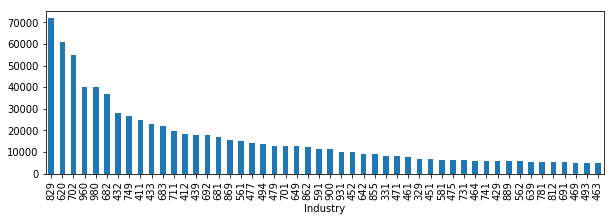

In [73]:
plot_frequency(wdf, 'Industry')

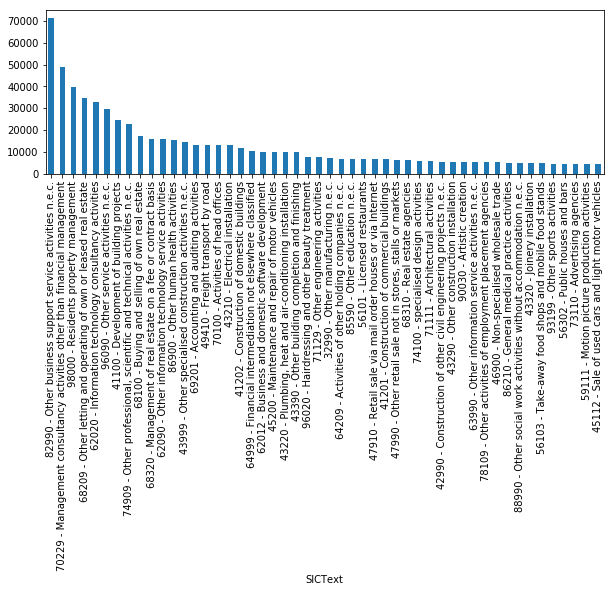

In [75]:
plot_frequency(wdf, 'SICText')

In [86]:
min_class_count = 300
classes = wdf.groupby(['Industry']).count().sort_values('CompanyName', ascending=False)
print(' Classes below %s samples: %s/%s' % (min_class_count, (classes.CompanyName < min_class_count).sum(), len(classes.CompanyName)))

 Classes below 300 samples: 84/273


In [102]:
classes[classes.CompanyName < min_class_count].head()

,CompanyName,SICC,WordSum,SICText
Industry,,,,
204,296,296,296,296
103,289,289,289,289
292,285,285,285,285
274,283,283,283,283
221,283,283,283,283


In [88]:
classes[classes.CompanyName < min_class_count].sum()

CompanyName    11643
SICC           11643
WordSum        11643
SICText        11643
dtype: int64

### Resample Data

In [93]:
to_replace = classes[classes.CompanyName < min_class_count].index

In [94]:
wdf['Industry'] = wdf['Industry'].replace(to_replace, '0')

In [96]:
# Remove unknown data
wdf = wdf[wdf['Industry'] != '0']
len(wdf)

1018245

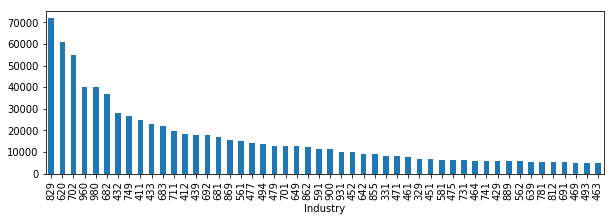

In [97]:
plot_frequency(wdf, 'Industry')

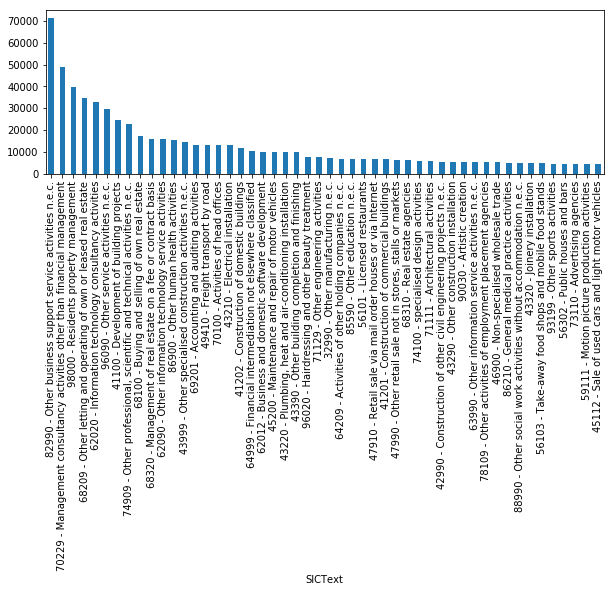

In [98]:
plot_frequency(wdf, 'SICText')

In [111]:
def resample_classes(df, groupby, samples):
    classes = wdf.groupby([groupby]).CompanyName.count()
    freqs = dict(5000/classes)
    freq = df[groupby].map(freqs)
    criteria = np.random.rand(len(df)) < freq
    return df[criteria]

In [112]:
rwdf = resample_classes(wdf, 'Industry', 5000)

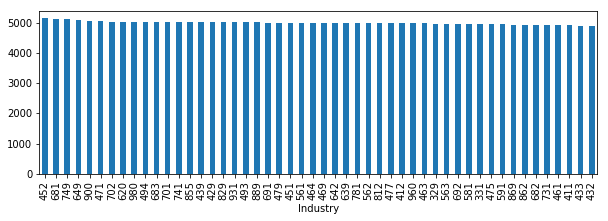

In [113]:
plot_frequency(rwdf, 'Industry')

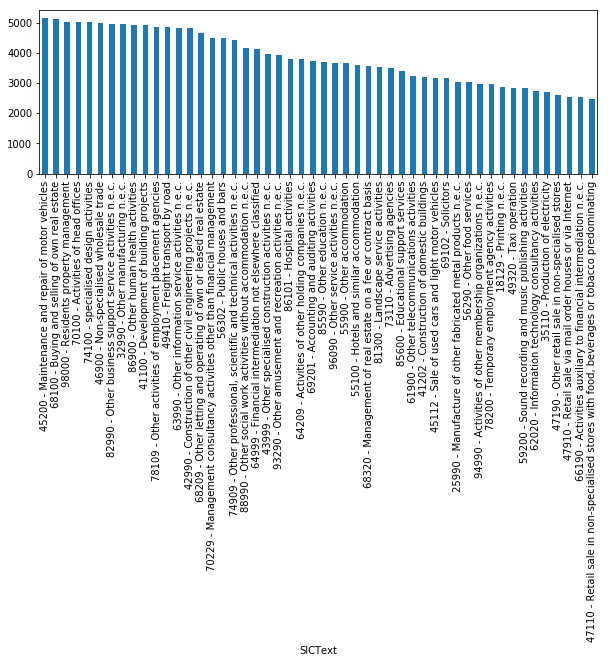

In [115]:
plot_frequency(rwdf, 'SICText')

### Pickle Working Set

In [100]:
feather.write_dataframe(wdf, 'wdf2m.feather')

In [ ]:
wdf = feather.read_dataframe('wdf2m.feather')
wdf.head()

### Label Encoding

In [117]:
industry_encoder = LabelEncoder()
industry_encoder.fit(rwdf['Industry'])
encoded_industry = industry_encoder.transform(rwdf['Industry'])
industry_labels = np_utils.to_categorical(encoded_industry)
industry_labels.shape

(454395, 189)

In [118]:
num_industries = industry_labels.shape[1]

### Text Encoding

In [10]:
def load_glove_embeddings(fp, embedding_dim, include_empty_char=True):
    """
    Loads pre-trained word embeddings (GloVe embeddings)
        Inputs: - fp: filepath of pre-trained glove embeddings
                - embedding_dim: dimension of each vector embedding
                - generate_matrix: whether to generate an embedding matrix
        Outputs:
                - word2coefs: Dictionary. Word to its corresponding coefficients
                - word2index: Dictionary. Word to word-index
                - embedding_matrix: Embedding matrix for Keras Embedding layer
    """
    # First, build the "word2coefs" and "word2index"
    word2coefs = {} # word to its corresponding coefficients
    word2index = {} # word to word-index
    with open(fp) as f:
        for idx, line in enumerate(f):
            try:
                data = [x.strip().lower() for x in line.split()]
                word = data[0]
                coefs = np.asarray(data[1:embedding_dim+1], dtype='float32')
                word2coefs[word] = coefs
                if word not in word2index:
                    word2index[word] = len(word2index)
            except Exception as e:
                print('Exception occurred in `load_glove_embeddings`:', e)
                continue
        # End of for loop.
    # End of with open
    if include_empty_char:
        word2index[''] = len(word2index)
    # Second, build the "embedding_matrix"
    # Words not found in embedding index will be all-zeros. Hence, the "+1".
    vocab_size = len(word2coefs)+1 if include_empty_char else len(word2coefs)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2index.items():
        embedding_vec = word2coefs.get(word)
        if embedding_vec is not None and embedding_vec.shape[0]==embedding_dim:
            embedding_matrix[idx] = np.asarray(embedding_vec)
    # return word2coefs, word2index, embedding_matrix
    return word2index, np.asarray(embedding_matrix)

In [11]:
word2index, embedding_matrix = load_glove_embeddings('glove.6B/glove.6B.100d.txt', embedding_dim=100)

In [12]:
def custom_tokenize(d):
    return [word2index.get(re.sub(r'[^\w\s]','',w).lower(), 0) for w in d.split()]

In [19]:
def sum_of_custom_tokenize(d):
    return sum(word2index.get(re.sub(r'[^\w\s]','',w).lower(), 0) for w in d.split())

In [120]:
vocab_size, embedding_dim = embedding_matrix.shape
maxlen = 10
print(custom_tokenize('This is an apple inc 10'))
print(custom_tokenize('what is this, an apple ltd?'))
vocab_size, embedding_dim

[37, 14, 29, 3292, 15231, 206]
[102, 14, 37, 29, 3292, 8196]


(400001, 100)

In [124]:
encoded_company_names = [custom_tokenize(d) for d in rwdf.CompanyName]
encoded_company_names = [d for d in encoded_company_names]

In [125]:
encoded_company_names = pad_sequences(encoded_company_names, maxlen=maxlen, padding='post')

In [126]:
# Sanity check
len(encoded_company_names), len(industry_labels)

(454395, 454395)

### Train/Test Split

In [127]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_company_names, industry_labels, test_size=0.2, random_state=42)
y_train.shape

(363516, 189)

### Model

In [128]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,
                            weights=[embedding_matrix], trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(num_industries, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 100)           40000100  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 189)               189189    
Total params: 40,189,289
Trainable params: 189,189
Non-trainable params: 40,000,100
_________________________________________________________________


### Hook up Tensorboard

`tensorboard --logdir='tmp'`

In [131]:
date_suffix = str(datetime.now()).replace(':', '-').split('.')[0]
temp_folder = 'tmp/GloVe%s-fd%s-industry-resampled-%s' % (
    embedding_dim, num_industries, date_suffix)
temp_folder

'tmp/GloVe100-fd189-industry-resampled-2018-03-22 15-30-04'

### Train Model

In [132]:
model.fit(
    X_train, y_train, epochs=8, batch_size=50,
    validation_data=(X_test, y_test),
    callbacks=[TensorBoard(log_dir=temp_folder)])

Train on 363516 samples, validate on 90879 samples
Epoch 1/20
363516/363516 [==============================] - 41s 112us/step - loss: 3.6331 - acc: 0.2267 - val_loss: 3.6130 - val_acc: 0.2311
Epoch 2/20
363516/363516 [==============================] - 41s 113us/step - loss: 3.6324 - acc: 0.2269 - val_loss: 3.6336 - val_acc: 0.2290
Epoch 3/20
363516/363516 [==============================] - 41s 113us/step - loss: 3.6317 - acc: 0.2270 - val_loss: 3.6240 - val_acc: 0.2311
Epoch 4/20
363516/363516 [==============================] - 43s 117us/step - loss: 3.6299 - acc: 0.2280 - val_loss: 3.6018 - val_acc: 0.2318
Epoch 5/20
363516/363516 [==============================] - 42s 116us/step - loss: 3.6295 - acc: 0.2270 - val_loss: 3.6115 - val_acc: 0.2340
Epoch 6/20
363516/363516 [==============================] - 42s 115us/step - loss: 3.6307 - acc: 0.2280 - val_loss: 3.6202 - val_acc: 0.2319
Epoch 7/20
363516/363516 [==============================] - 42s 115us/step - loss: 3.6305 - acc: 0.2274

KeyboardInterrupt: 

### Testing/Validation

In [133]:
loss, accuracy = model.evaluate(X_test, y_test)
accuracy

90879/90879 [==============================] - 3s 36us/step


0.23394843693000122

In [134]:
y_labels = np.argmax(y_test, axis=1)
y_pred = model.predict_classes(X_test)
y_labels.shape, y_pred.shape

((90879,), (90879,))

In [135]:
print('Verifying accuracy', (y_labels==y_pred).sum()/len(y_pred))

Verifying accuracy 0.233948436933


In [164]:
def plot_confusion_matrix(cm, classes):
    pylab.clf()
    cm = cm/cm.sum(axis=0)
    pylab.matshow(cm, fignum=False, cmap='Blues', vmin=0, vmax=0.5)
    pylab.colorbar()
    pylab.grid(False)
    pylab.xlabel('Predicted')
    pylab.ylabel('Actual')
    pylab.show()

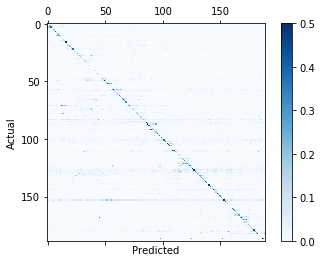

In [165]:
cm = confusion_matrix(y_pred, y_labels)
plot_confusion_matrix(cm, [])

In [155]:
cm_scaled = cm/cm.sum(axis=0)
acc_per_class = pd.Series(np.diag(cm_scaled))
acc_per_class = acc_per_class.reset_index()
acc_per_class['class'] = industry_encoder.inverse_transform(acc_per_class.index)
acc_per_class['num'] = cm.sum(axis=0)

In [156]:
acc_per_class

,index,0,class,num
0,0,0.012097,011,496
1,1,0.000000,012,60
2,2,0.243299,014,485
3,3,0.387464,015,351
4,4,0.062130,016,338
5,5,0.140187,021,107
6,6,0.139535,024,129
7,7,0.440678,031,177
8,8,0.093960,061,149
9,9,0.200000,081,55


In [160]:
print(wdf[wdf.Industry == '811'].head(20))

                                            CompanyName   SICC  WordSum  \
314   BELL MOOR  PORTARLINGTON ROAD MANAGEMENT COMPANY   81100   196056   
529                              MIG CONTRACT SERVICES   81100    34506   
1803                          &  AVONMOR MEWS FREEHOLD   81100   526242   
1807                     &  CLIFTON TERRACE MANAGEMENT   81100   432310   
2004                     BUCKLAND CRESCENT RTM COMPANY   81100   147036   
2065                 CLAREMONT ROAD MANAGEMENT COMPANY   81100    25850   
2112                                 CROMWELL CRESCENT   81100    31513   
2145                            DERHAM ROAD MANAGEMENT   81100   163534   
2226           GOLDNEY ROAD CLIFTON MANAGEMENT COMPANY   81100   273429   
2258                          HARECOURT ROAD ISLINGTON   81100    39834   
2402                           MARKET STREET WOODSTOCK   81100    17634   
2479              PARK ROAD IPSWICH MANAGEMENT COMPANY   81100    18023   
2483                     

### Save Model

In [158]:
model.save('models/train%s-acc%s.h5' % (len(X_train), accuracy))

### Play with Model

In [161]:
while True:
    name = input()
    if not name:
        break
    encoded_company_name = pad_sequences([custom_tokenize(name)], maxlen=maxlen, padding='post')
    probas = sorted(enumerate(model.predict(encoded_company_name).flatten()), key=lambda x: x[1], reverse=True)[:5]
    for i, p in probas:
        print('\t%0.2f%%\t%s' % (p*100, industry_encoder.inverse_transform(i)[:100]))

10 BELSIZE PARK GARDENS MANAGEMENT COMPANY
	99.20%	980
	48.18%	559
	33.86%	683
	14.84%	811
	2.39%	682

